In [1]:
using LinearAlgebra

include("../src/tebd.jl")
using .TimeEvolvingBlockDecimation
using .TimeEvolvingBlockDecimation.MatrixProductState

Let's initialize a 12 qubit state in the $|0\cdots0\rangle$ state. Normally we would work with the representation 
$$|\psi\rangle=\left(\begin{matrix}
    1\\
    0\\
    0\\
    \vdots\\
    0
\end{matrix}\right)$$
with $$|\psi\rangle\in C^{\left(2^{12}\right)}$$
But instead we'll expand the tensor products implicit in $$|00\cdots0\rangle=|0\rangle\otimes|0\rangle\otimes\cdots$$ explicitly by writing out the full tensor. In other words we will instead use
    $$|\psi\rangle\in C^{2\times2\times\cdots\times2}$$
    with
    $$(|\psi\rangle)_{00\cdots0}=1.$$

In [2]:
sites = 10 # TODO: revert to 12 when back in Berkeley (laptop can't handle)
ψ = zeros((2 for _=1:sites)...)
ψ[(1 for _=1:sites)...] = 1;

Now we convert $|\psi\rangle$ into an MPS:

In [3]:
ψ_mps = mps(ψ);

With this representation, it is much less constly to apply local operators to the state $|\psi\rangle$. Instead of calculating the matrix exponential $e^{-i\hat{H}t}$ using the full hamiltonian $\hat{H}$, we can apply one- or two-local operators at each site in the chain, reinforce the maximum allowed bond dimension, and repeat for each site or pair of sites that is included in $\hat{H}$.

In [4]:
# Define Pauli basis and tensor product shorthand.
# Use t=π/6 for this example.
⊗ = kron
I = [1 0; 0 1]
σ_x = [0 1; 1 0]
σ_y = [0 -1im; 1im 0]
σ_z = [1 0; 0 -1]

t = π / 6;

First, let's calculate the time-evolved state
$$|\psi(t)\rangle = exp\left\{-i\hat{H}t\right\}|\psi\rangle,$$
where the Hamiltonian
$$\hat{H}=\sum_i\sigma_x^{(i)}$$
is a time-independent sum of single-qubit operators. The extremely naive method to calculate $|\psi(t)\rangle$ is to first calculate the matrix exponential, then do a matrix-vector multiplication. Let's do it this way first:

In [6]:
# The not as fast way

# Helper function for calculating H. We only use local terms in this example.
function ising_matrix(sites::Integer, local_only::Bool = false)
        I = [
            1 0
            0 1
        ]
        identity_string = [I for _ = 1:sites]
        local_term = zeros(2^sites, 2^sites)
        interaction_term = zeros(2^sites, 2^sites)

        for i = 1:sites
            pauli_string = copy(identity_string)
            pauli_string[i] = σ_x
            local_term += reduce(kron, pauli_string)
        end

        for i = 1:sites-1
            pauli_string = copy(identity_string)
            pauli_string[i] = σ_z
            pauli_string[i+1] = σ_z
            interaction_term += reduce(kron, pauli_string)
        end
        if local_only
            return local_term
        end
        return interaction_term + local_term
end

# Only use local terms for H:
H = ising_matrix(sites, true)
ψ_vect = zeros(2^sites)
ψ_vect[1] = 1

# Naive method: do the matrix exponential followed by a matrix-vector multiplication.
@time ψ_res_vect = exp(H * t * -1im) * ψ_vect

  4.196261 seconds (37 allocations: 248.045 MiB, 0.87% gc time)


1024-element Vector{ComplexF64}:
     0.2373046875000001 + 0.0im
                    0.0 - 0.137007925208085im
                    0.0 - 0.13700792520808497im
   -0.07910156249999999 + 0.0im
                    0.0 - 0.1370079252080851im
   -0.07910156249999994 + 0.0im
   -0.07910156250000007 + 0.0im
                    0.0 + 0.045669308402695im
                    0.0 - 0.13700792520808497im
          -0.0791015625 + 0.0im
   -0.07910156250000004 + 0.0im
                    0.0 + 0.04566930840269503im
   -0.07910156249999994 + 0.0im
                        ⋮
                    0.0 + 0.005074367600299446im
  0.0029296874999999913 + 0.0im
   0.002929687499999991 + 0.0im
                    0.0 - 0.001691455866766455im
                    0.0 + 0.005074367600299432im
  0.0029296874999999883 + 0.0im
  0.0029296874999999822 + 0.0im
                    0.0 - 0.0016914558667664552im
  0.0029296874999999853 + 0.0im
                    0.0 - 0.0016914558667664656im
                    0.0 - 0

Thanks to the `@time` macro, we can see that this calculation takes about 20 seconds and uses a whole lot of memory. Pretty bad, but this is an extremeley naive way of doing things, especially since our initial state is unentangled and the Hamiltonian we're time-evolving under doesn't generate additional entanglement. Using block evolution on a MPS representation of $|\psi\rangle$ effectively takes advantage of this structure. With this method, we only do twelve $2\times2$ matrix-vector multiplications, and since our initial state was unentangled the result is exact. Were our initial state (or system Hamiltonian) more highly entangled (entangling) the MPS representation (block evolution) would do a poorer job approximating the full matrix multiplication.

In [8]:
# The fast way
local_only_ising = Hamiltonian(0 * (σ_z ⊗ σ_z), σ_x)
@time ψ_res = reshape(contract_mps(block_evolve(ψ_mps, local_only_ising, t * -1im)), 2^sites)

  0.034609 seconds (48.34 k allocations: 5.986 MiB, 77.27% gc time)


1024-element Vector{ComplexF64}:
    0.2373046875000009 + 0.0im
                   0.0 - 0.13700792520808547im
                   0.0 - 0.13700792520808547im
  -0.07910156250000024 + 0.0im
                   0.0 - 0.13700792520808552im
  -0.07910156250000026 + 0.0im
  -0.07910156250000026 + 0.0im
                   0.0 + 0.04566930840269513im
                   0.0 - 0.13700792520808555im
  -0.07910156250000028 + 0.0im
  -0.07910156250000026 + 0.0im
                   0.0 + 0.04566930840269514im
  -0.07910156250000026 + 0.0im
                       ⋮
                   0.0 + 0.005074367600299462im
 0.0029296875000000082 + 0.0im
 0.0029296875000000087 + 0.0im
                   0.0 - 0.001691455866766486im
                   0.0 + 0.005074367600299463im
 0.0029296875000000087 + 0.0im
  0.002929687500000009 + 0.0im
                   0.0 - 0.0016914558667664862im
 0.0029296875000000087 + 0.0im
                   0.0 - 0.001691455866766486im
                   0.0 - 0.001691455866766486im

To prove the two results are equal:

In [9]:
dot(ψ_res_vect, ψ_res)

1.0000000000000029 + 0.0im

Let's switch to a full 1D Ising model. Now
$$\hat{H}=\sum_{i=1}^{N-1}\sigma_z^{(i)}\sigma_z^{(i+1)}+J\sum_{i=1}^N\sigma_x^{(i)}$$
where $J$ tunes the relative strength of the transverse field. For this example we set $J=1.$

Since now $\hat{H}$ generates entanglement, the fidelity of the block-evolved state will not be as high as $t$ grows.

In [10]:
# The not as fast way
t = π/6
# Set H to the full ising matrix as above:
H = ising_matrix(sites, false)
ψ_vect = zeros(2^sites)
ψ_vect[1] = 1

# Naive method: do the matrix exponential followed by a matrix-vector multiplication.
@time ψ_res_vect = exp(H * t * -1im) * ψ_vect

  5.026258 seconds (41 allocations: 280.045 MiB, 2.88% gc time)


1024-element Vector{ComplexF64}:
     0.2602045137070336 + 0.2813759452698945im
    0.19716848263720943 - 0.028506423577333146im
    0.14237969451763452 + 0.06916214188218567im
    0.02853140304332385 - 0.10164902485893475im
    0.14220403968075787 + 0.06325618373067858im
     0.0717332409468644 - 0.04057177294676267im
     0.0741391665573922 - 0.0589484220455397im
   -0.04277587496395974 - 0.03547508091993412im
    0.14242537104033834 + 0.06353640387577862im
    0.06898902429473938 - 0.04225693786342524im
    0.06480771479875375 + 0.0057809195873058826im
 -0.0042641749124536395 - 0.04345957173698785im
    0.07094605569298025 - 0.059527306974765985im
                        ⋮
  0.0033473078142319413 + 2.0544933593724354e-5im
  0.0010649408015829542 - 0.0014178677059549227im
  0.0009457353322052501 - 0.0018174064642030529im
  -0.001155991580815673 - 0.0003227554157262753im
  0.0030557260553333862 - 0.0029817107066037723im
 -0.0003768111807027146 - 0.0021826572117196797im
  0.00079499290

In [11]:
ising = Hamiltonian(σ_z ⊗ σ_z, σ_x)
@time ψ_res = reshape(contract_mps(block_evolve(ψ_mps, ising, t * -1im)), 2^sites)

  0.005125 seconds (48.34 k allocations: 5.989 MiB)


1024-element Vector{ComplexF64}:
     0.16105293192095316 + 0.2844221366739287im
     0.14898949454161498 + 0.11581650754419004im
    0.049692800431491976 + 0.1489450411651847im
     0.08599345961117927 - 0.02869015170590819im
     0.04969280043149184 + 0.14894504116518478im
    0.059557624502061104 + 0.06834390436958543im
     0.07277554205662023 + 0.019826876331838605im
     0.01144705238737645 - 0.04201697879681059im
     0.04969280043149189 + 0.14894504116518473im
     0.05955762450206112 + 0.06834390436958539im
    0.009688861100079826 + 0.074803145102972im
      0.0431876159614315 - 0.0055938665642719584im
     0.07277554205662023 + 0.019826876331838623im
                         ⋮
   0.0011595722836621732 + 0.0020084381103515543im
   0.0010639702969013139 + 0.0008128823502584728im
   0.0011117712902817434 + 7.170149007064395e-5im
    4.139687459358372e-5 - 0.0006418814537214617im
    0.002299932210963807 - 0.00029789821939910023im
   0.0011595722836621716 - 0.0006694793701171839

In [12]:
dot(ψ_res_vect, ψ_res)

0.3897138280372172 + 0.7468023667473049im

The single-pass TEBD state $|\psi\rangle$ is not a very good approximation to the true time-evolved target state $|\phi\rangle$. This is expected since even disregarding the fact that we used a matrix product state, 
    $$e^{-i\left(\sum_{i=1}^NZ_iZ_{i+1}+\sum_{i=1}^NX_i\right)t}\neq\prod_{i=1}^{N-1}e^{-iZ_iZ_{i+1}t}\prod_{i=1}^{N}e^{-iX_it}$$
More succinctly, a single pass of TEBD is essentially a [Trotter Decomposition](https://en.wikipedia.org/wiki/Time-evolving_block_decimation#The_Suzuki%E2%80%93Trotter_expansion) for approximating time evolution under $\hat{H}$.

To better approximate the target state $|\phi\rangle$, we can instead do ten passes of block evolution and increase the bond dimension of $|\psi\rangle$, sacrificing memory and runtime:

In [13]:
ψ_mps_high_χ = mps(ψ, 2^(sites ÷ 2))
@time ψ_res_better = reshape(contract_mps(tebd(ψ_mps_high_χ, ising, t * -1im, 10)), 2^sites)
dot(ψ_res_better, ψ_res_vect)

  1.335698 seconds (12.72 M allocations: 2.119 GiB, 15.50% gc time, 14.57% compilation time)


0.99585064530724 - 0.07634417930545673im

Let's visualize time evolution under the two Hamiltonians we've just discussed. We'll evaluate the expectation value $\langle\sigma_z\rangle$ on each site in the chain over a time period that amounts to a single full rotation under $\hat{H}$. We can plot the resulting values under a few different bond dimensions $\chi$:

In [69]:
using Images, ColorSchemes, Plots

# Simulate time evolution under a 1D ising with and without local
# interactions. Evolve
function run_simulation(χ)
    ψ_mps_med_χ = mps(ψ, χ)
    
    ψ_evolved = ψ_mps_med_χ
    ising_vals = []
    res = 50
    println("Ising model")
    @time for t in 1:res
        ψ_evolved = tebd(ψ_evolved, ising, -1im * 2 * π / res, 20)
        expectations = []
        for site in 1:sites
            push!(expectations, eval_local_op(ψ_evolved, σ_z, site))
        end
        push!(ising_vals, expectations)
    end

    ψ_evolved = ψ_mps_med_χ
    local_vals = []
    println("Transverse magnetic field")
    @time for t in 1:res
        ψ_evolved = tebd(ψ_evolved, local_only_ising, -1im * 2 * π / res, 10)
        expectations = []
        for site in 1:sites
            push!(expectations, eval_local_op(ψ_evolved, σ_z, site))
        end
        push!(local_vals, expectations)
    end
    offset = x->(x+1)/2
    ising_sites_over_time = offset.(real.(transpose(hcat(ising_vals...))))
    local_sites_over_time = offset.(real.(transpose(hcat(local_vals...))))

    function colormap(x)
        return get(ColorSchemes.matter, x)
    end

    ising_visual = colormap.(ising_sites_over_time)
    local_visual = colormap.(local_sites_over_time)

    display("Expectation of σ_z for each site over time")
    display("Local interation only (σ_x):")
    display(local_visual)
    display("Ising model:")
    display(ising_visual)
    
    undo_offset = x -> 2 * x - 1

    leftmost_vals_local = local_sites_over_time[:, 1]
    middle_vals_local = local_sites_over_time[:, 6]

    leftmost_vals_ising = ising_sites_over_time[:, 1]
    middle_vals_ising = ising_sites_over_time[:, 6]

    steps = Array(1:res)
    
    # Plot expectation without nearest neighbor interactions
    p1 = plot(steps,
         undo_offset.(leftmost_vals_local),
         label="leftmost",
         title="⟨σ_z⟩ over t (no neighbor interations, χ="*string(χ)*")")
    for i in 2:sites
        plot!(p1,
             steps,
             undo_offset.(local_sites_over_time[:, i]),
             label="site " * string(i)
            )
    end

    # Plot expectation with nearest neighbor interactions
    p2 = plot(steps,
         undo_offset.(leftmost_vals_ising),
         label="leftmost",
         title="⟨σ_z⟩ over t (with neighbor interactions, χ="*string(χ)*")")
    for i in 2:sites
        plot!(p2,
             steps,
             undo_offset.(ising_sites_over_time[:, i]),
             label="site " * string(i)
            )
    end

    display(p1)
    display(p2)
end

run_simulation (generic function with 1 method)

Ising model
  2.779647 seconds (23.05 M allocations: 5.055 GiB, 14.11% gc time)
Transverse magnetic field


"Expectation of σ_z for each site over time"

"Local interation only (σ_x):"

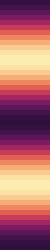

"Ising model:"

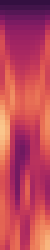

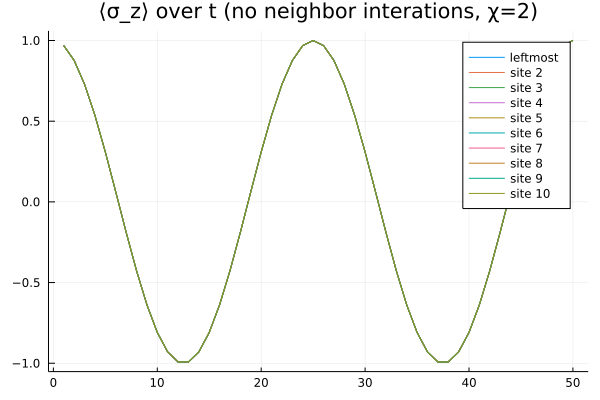

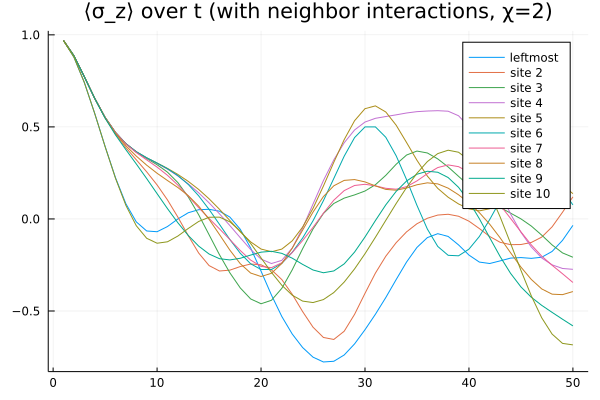

  1.472011 seconds (11.73 M allocations: 2.537 GiB, 12.79% gc time)


In [70]:
run_simulation(2)

Ising model
 23.359809 seconds (258.40 M allocations: 50.683 GiB, 15.81% gc time)
Transverse magnetic field


"Expectation of σ_z for each site over time"

"Local interation only (σ_x):"

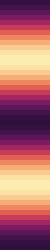

"Ising model:"

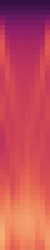

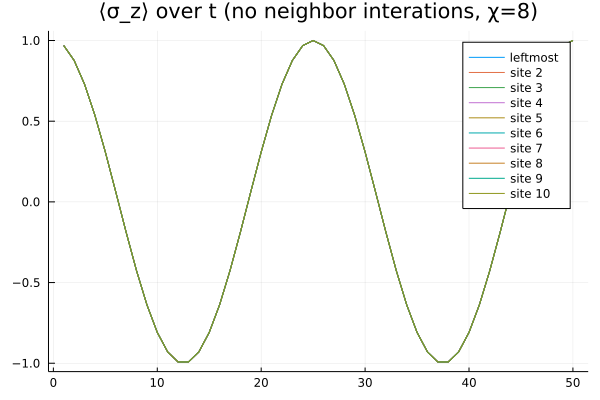

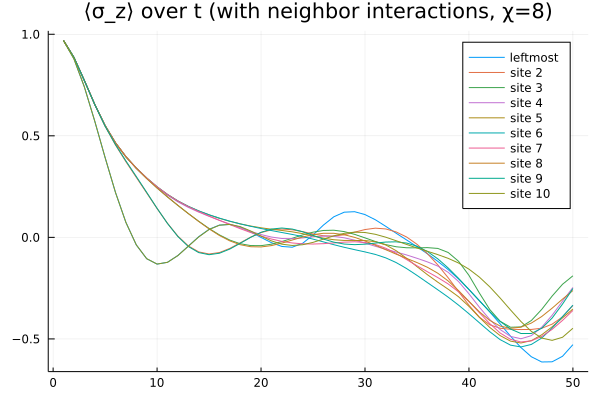

 14.033331 seconds (133.18 M allocations: 25.518 GiB, 14.91% gc time)


In [71]:
run_simulation(2^3)

Ising model
 69.892646 seconds (754.88 M allocations: 130.907 GiB, 15.08% gc time)
Transverse magnetic field


"Expectation of σ_z for each site over time"

"Local interation only (σ_x):"

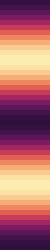

"Ising model:"

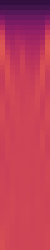

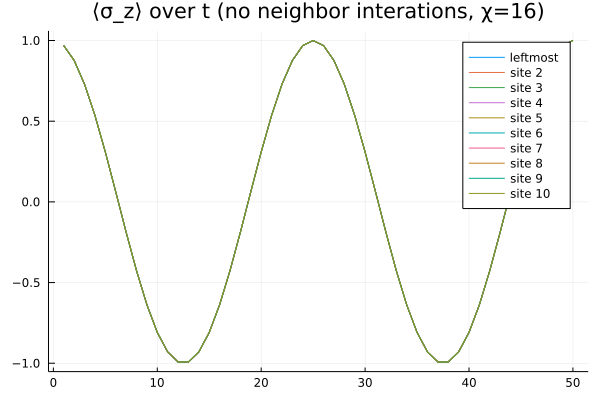

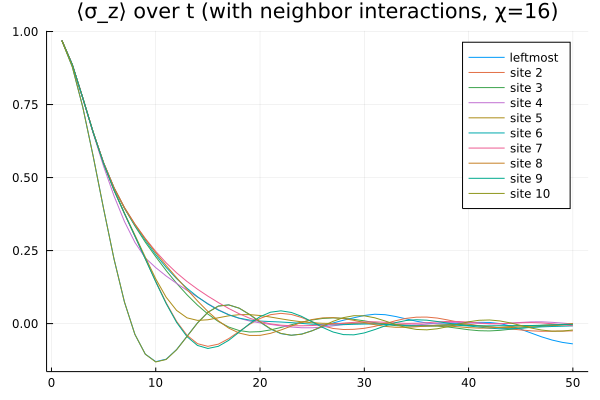

 34.254232 seconds (394.61 M allocations: 66.207 GiB, 14.99% gc time)


In [72]:
run_simulation(2^4)

Ising model
129.666780 seconds (1.29 G allocations: 212.728 GiB, 13.88% gc time)
Transverse magnetic field


"Expectation of σ_z for each site over time"

"Local interation only (σ_x):"

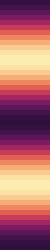

"Ising model:"

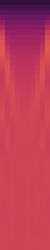

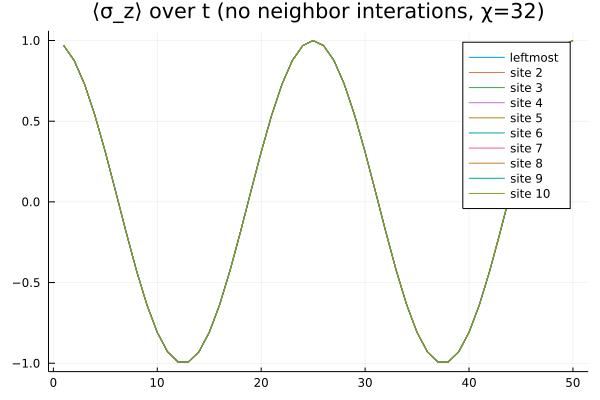

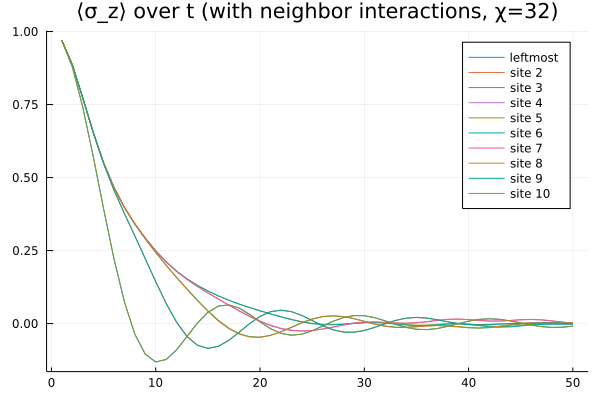

 66.601874 seconds (682.30 M allocations: 108.093 GiB, 14.04% gc time)


In [73]:
run_simulation(2^5)